In [2]:
!pip install d2l

     |████████████████████████████████| 81kB 5.8MB/s 


In [3]:
#4.4.4. 多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
# 4.4.4.1. 生成数据集
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# 同样，存储在poly_features中的单项式由gamma函数重新缩放，其中 Γ(n)=(n−1)! 。从生成的数据集中查看前2个样本。值1是与偏置相对应的常量特征。
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8497],
         [ 0.2535]]),
 tensor([[ 1.0000e+00, -8.4973e-01,  3.6102e-01, -1.0226e-01,  2.1723e-02,
          -3.6918e-03,  5.2284e-04, -6.3468e-05,  6.7413e-06, -6.3648e-07,
           5.4084e-08, -4.1779e-09,  2.9584e-10, -1.9338e-11,  1.1737e-12,
          -6.6489e-14,  3.5311e-15, -1.7650e-16,  8.3321e-18, -3.7264e-19],
         [ 1.0000e+00,  2.5350e-01,  3.2130e-02,  2.7150e-03,  1.7206e-04,
           8.7233e-06,  3.6856e-07,  1.3347e-08,  4.2292e-10,  1.1912e-11,
           3.0197e-13,  6.9590e-15,  1.4701e-16,  2.8666e-18,  5.1905e-20,
           8.7718e-22,  1.3898e-23,  2.0724e-25,  2.9186e-27,  3.8939e-29]]),
 tensor([2.1836, 5.1267]))

In [6]:
# 4.4.4.2. 对模型进行训练和测试
# 首先让我们实现一个函数来评估模型在给定数据集上的损失。
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
#定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9943953  1.1961334 -3.4056523  5.5839186]]


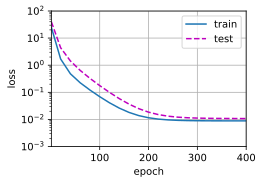

In [8]:
# 4.4.4.3. 三阶多项式函数拟合(正态)
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.034018 4.059775]]


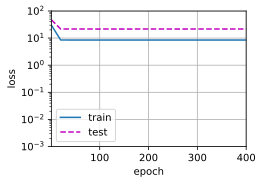

In [9]:
# 4.4.4.4. 线性函数拟合(欠拟合)
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.996515    1.2541891  -3.4330683   5.2493877   0.06717931  1.0639406
   0.12412578  0.18620613 -0.05328059  0.16344531 -0.07446958  0.13235265
  -0.1473267  -0.11582308  0.09169664 -0.14216176  0.06111916  0.11133367
  -0.09018873 -0.11769582]]


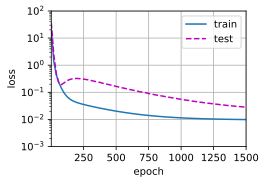

In [10]:
# 4.4.4.5. 高阶多项式函数拟合(过拟合)
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)